# Dependencies

In [91]:
import numpy as np
import scipy as sp
import seaborn as sn
import pandas as pd
import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.animation
import time
from IPython.display import HTML, Image, Video
from tqdm import tqdm
import os
import xarray as xr
import gc
import multiprocessing
import glob

from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## Matplotlib rcparams setup:
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')
## textwidth of Thesis
textwidth = 5.848611111111111
## palette
palette = get_palette.color_blind().to_sn_palette()

%matplotlib inline

# Introduction
This notebook uses the Lorenz '63 system to demonstrate the conceptual differences between conventional "probabilistic" climate-model based attribution and our forecast-based approach. 

The specific system used is the Palmer '99 variant of the Lorenz dynamical model, which includes a forcing (at an angle $\theta$ in the xy place) to the system, representing some external forcing - eg. anthropogenic greenhouse gas emissions. The equations of this system are as follows:

$
\begin{align}
\dot{x} & = \sigma(y-x) + f_0 \cos\theta \\
\dot{y} & = x (\rho - z) - y + f_0 \sin\theta \\
\dot{z} & = xy - \beta z
\end{align}
$

Lorenz, E. N. (1963). Deterministic Nonperiodic Flow. Journal of the Atmospheric Sciences. [DOI](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2)

Palmer, T. N. (1999). A Nonlinear Dynamical Perspective on Climate Prediction. Journal of Climate, 12(2), 575–591. [DOI](https://doi.org/10.1175/1520-0442(1999)012<0575:ANDPOC>2.0.CO;2)

In [ ]:
def lorenz(xyz, t, rho=28, sigma=10, beta=8/3, F=0, theta=0):
    
    "Defines the lorez63 dynamical system. Standard default values."
    
    x, y, z = xyz
    x_dot = sigma * (y - x) + F * np.cos(theta)
    y_dot = x * rho - x * z - y + F * np.sin(theta)
    z_dot = x * y - beta * z
    return [x_dot, y_dot, z_dot]

# set Lorenz system parameters
s = 10
r = 28
b = 8/3
F = (8,np.deg2rad(-40))

# Definitions

## Locate analogues
We'll do this with numpy because MUCH easier

In [3]:
def get_analogs(event,ds,n=100):
    
    ds = ds.copy()
    ds['ED'] = (((ds - event)**2).to_array().sum('variable')**(1/2))
    
    def preproc_ED(ds):
    
        ds = ds.copy()
        ds = ds.sortby('ED')
        ds['time0'] = ds.time

        return ds.rename(time='rank').assign_coords(rank=np.arange(ds.time.size))

    ds = xr.concat([preproc_ED(ds.sel(type=x)) for x in ds.type.values],dim='type')
    
    return ds.isel(rank=range(n))

In [4]:
event = ds.sel(type='forced',time=ds.sel(type='forced').x.idxmax())

In [5]:
get_analogs(event,ds)

<xarray.Dataset>
Dimensions:  (rank: 100, type: 2)
Coordinates:
  * type     (type) object 'unforced' 'forced'
  * rank     (rank) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
    branch   int64 100
Data variables:
    x        (type, rank) float64 19.14 19.11 19.13 19.04 ... 18.8 19.05 19.08
    y        (type, rank) float64 19.46 19.42 19.1 19.28 ... 18.39 19.48 19.55
    z        (type, rank) float64 42.22 42.17 42.49 42.12 ... 41.04 40.74 40.75
    ED       (type, rank) float64 0.4745 0.4757 0.4762 ... 1.542 1.552 1.556
    time0    (type, rank) float64 1.003e+07 1.009e+07 ... 1.007e+07 1.006e+07

## Get extremes
Get the most extreme event in each "wing".

In [6]:
def preprocess_to_extremes(ds):
    
    return xr.concat([ds.sel(time=ds.x.idxmax('time')).expand_dims({'event':['max']}),ds.sel(time=ds.x.idxmin('time')).expand_dims({'event':['min']})],'event')

In [7]:
ds_event = []

for fpath in tqdm(sorted(glob.glob('Lorenz63-realisations/*'))[1:]):
    
    ds = xr.open_mfdataset(fpath,preprocess=preprocess_to_extremes)
    
    ds_event += [ds.copy()]
    
    ds.close()

100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


In [12]:
extremes = xr.concat(ds_event,dim='branch').load()

### Select specific extreme event

In [57]:
## choose nearest event to 19.6 in the forced attractor
event = xr.open_dataset('Lorenz63-realisations/'+"{:04.0f}".format(np.fabs(extremes.sel(event='max',type='forced').x-19.6).idxmin().values)+'.nc')

event_time = event.sel(type='forced').x.argmax('time')

In [61]:
ic_times = xr.DataArray(data=[0,-10,-20,-50,-100,-200,-500,-1000],dims=['lead'],coords={'lead':[0,0.1,0.2,0.5,1,2,5,10]})

In [68]:
ics = event.sel(type='forced').isel(time=event_time+ic_times)

# Explore "full" attractor

In [75]:
full = xr.open_mfdataset('Lorenz63-realisations/005*.nc',preprocess=lambda x:x.squeeze())
full = full.load()

In [76]:
full

<xarray.Dataset>
Dimensions:  (time: 100000000, type: 2)
Coordinates:
  * type     (type) object 'unforced' 'forced'
  * time     (time) float64 5e+06 5e+06 5e+06 5e+06 ... 6e+06 6e+06 6e+06 6e+06
    branch   (time) int64 50 50 50 50 50 50 50 50 50 ... 59 59 59 59 59 59 59 59
Data variables:
    x        (type, time) float64 -3.38 -2.726 -2.134 -1.6 ... 1.239 0.8 0.4038
    y        (type, time) float64 3.477 3.501 3.492 3.462 ... -3.99 -3.98 -3.974
    z        (type, time) float64 30.38 29.48 28.62 27.8 ... 26.18 25.45 24.75

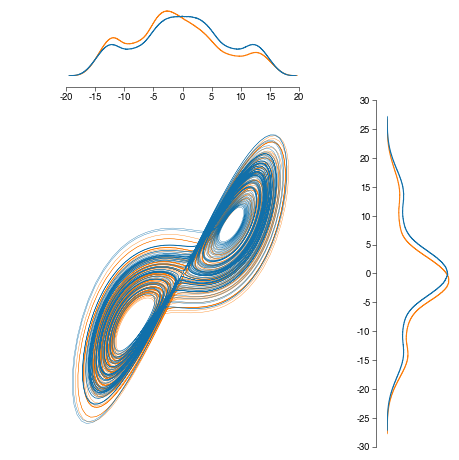

In [161]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(5,5,figure=fig)

ax = fig.add_subplot(gs[1:,:-1])
ax_x = fig.add_subplot(gs[0,:-1])
ax_y = fig.add_subplot(gs[1:,-1])

## plot main butterfly
ax.plot(*full.isel(time=range(10000)).sel(type='forced').to_array().variable.values[:2],color=palette[1],lw=0.33)
ax.plot(*full.isel(time=range(10000)).sel(type='unforced').to_array().variable.values[:2],color=palette[0],lw=0.33)

## plot distributions
ax_x.hist(full.sel(type='forced').x.values,histtype='step',color=palette[1],lw=1)
ax_x.hist(full.sel(type='unforced').x.values,histtype='step',color=palette[0],lw=1)
ax_y.hist(full.sel(type='forced').y.values,orientation='horizontal',histtype='step',color=palette[1],lw=1)
ax_y.hist(full.sel(type='unforced').y.values,orientation='horizontal',histtype='step',color=palette[0],lw=1)

# axes layout options
ax.axis('off')
ax_x.set_yticks([])
ax_x.set_xticks(np.arange(-20,21,5))
ax_y.set_xticks([])
ax_y.set_yticks(np.arange(-30,31,5))

sn.despine(ax=ax_x,left=True,offset=10,trim=True)
sn.despine(ax=ax_y,bottom=True,offset=10,trim=True)

[a.set_xlim(-30,30) for a in [ax,ax_x]]
[a.set_ylim(-30,30) for a in [ax,ax_y]]

## output figure options
fig.patch.set_facecolor('xkcd:white')
aspect = 1
fig.set_size_inches(textwidth,textwidth*aspect)
plt.tight_layout(w_pad=0,h_pad=0)
fig.dpi=80

## Statistics of exceedence likelihood

# Initialised attribution

In [ ]:
analogs = []

for fpath in tqdm(sorted(glob.glob('Lorenz63-realisations/*'))[1:]):
    
    ds = xr.open_dataset(fpath).squeeze()
    
    def get_all_leads(lead):

        return get_analogs(event=ics.sel(lead=lead).squeeze(),ds=ds)
    
    P1 = multiprocessing.Pool(processes=4)
    analogs += [xr.concat(P1.map(get_all_leads,ics.lead.values),dim='lead')]
    P1.close()